In [49]:
# Standard imports
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Project-specific helper functions
from feature_func_inline import *  # This loads remove_outliers, log_transform, etc.

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [50]:
training_data = pd.read_csv("data/cook_county_train.csv", index_col='Unnamed: 0')

As a good sanity check, I verify that the data shape matches the description.

In [51]:
# 204,792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values

In [52]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

In [53]:
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [54]:
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
0,17294100610000,203,50,2500.0,76,0.0,2.0,1.0,1.0,3.0,...,9,2,1.0,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.",2500.0
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,5,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.",3780.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,2,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-story houeshold located at 11415 S PRAIRIE AVE.It has a total of 7 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.",4375.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,7,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-story with partially livable attics houeshold located at 2012 DOBSON ST.It has a total of 5 rooms, 3 of which are bedrooms, and 1.5 of which are bathrooms.",4375.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-story houeshold located at 104 SAUK TRL.It has a total of 5 rooms, 2 of which are bedrooms, and 1.0 of which are bathrooms.",8400.0


Each row represents a sale of a property in Cook County, which contains attributes of the property such as lot size, neighborhood code, etc.

I think this data was collected to track the changes that has occured to the properties in Cook County. One could analyze property market price trends, track renovations to the wall, roof, basement, garage, and even see how often properties are being sold to understand the general property market selling/buying behaviors. This is information useful to the city, investors in real estate, and the average buyer interested in gauging when to buy or sell.

In [55]:
training_data['Sale Month of Year'].mode()

0    8
Name: Sale Month of Year, dtype: int64

I question whether older people buy older properties. To answer this, I create a scatter plot using the "Age Decade" colum of training_data and the age column of the demographic dataset. I check whether there is any pattern or concentration in the scatterplot visually then perhaps map a KDE plot to further study the density.

In [56]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

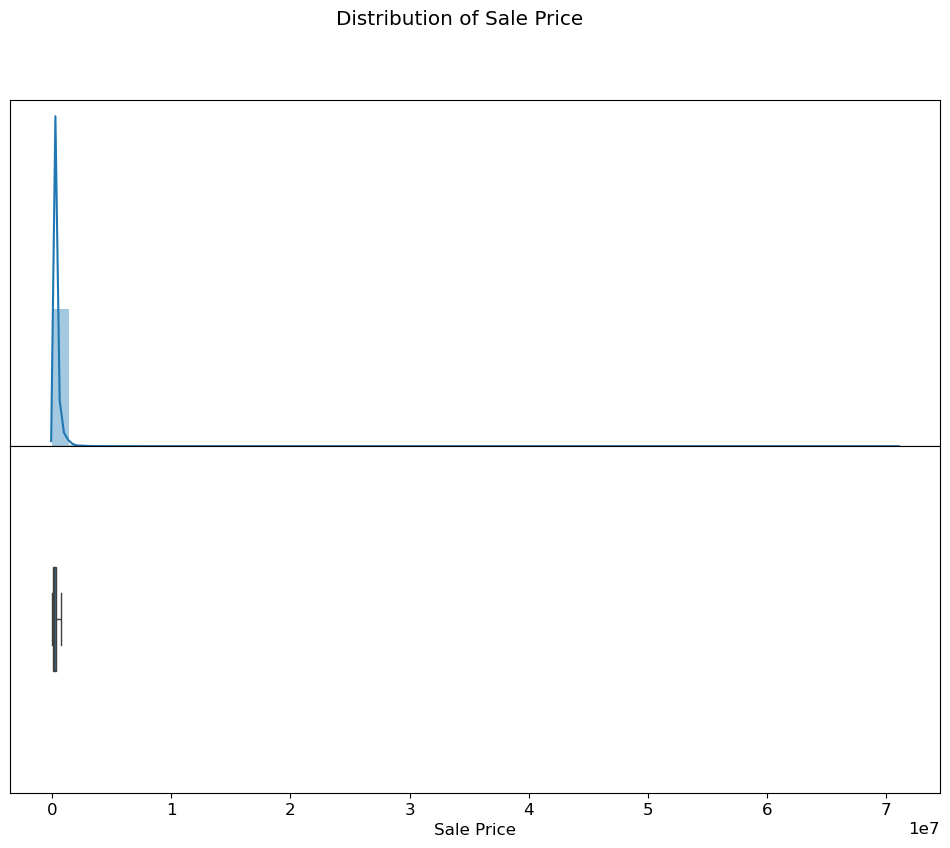

In [57]:
plot_distribution(training_data, label='Sale Price')

I also take a look at some descriptive statistics of this variable.

In [58]:
training_data['Sale Price'].describe()

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

The visualization is skeId to the left by a lot, which could be a result of outliers embodying extraordinarily expensive properties. To fix this, I can rescale the data spread through log transformations. I can also simply remove the outliers, but this is bad practice since it jeapardizes data integrity. 

In [59]:
training_data = training_data[training_data['Sale Price'] >= 500]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.",3780.0,12.560244
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-story houeshold located at 11415 S PRAIRIE AVE.It has a total of 7 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.",4375.0,9.998798
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-story with partially livable attics houeshold located at 2012 DOBSON ST.It has a total of 5 rooms, 3 of which are bedrooms, and 1.5 of which are bathrooms.",4375.0,12.323856
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-story houeshold located at 104 SAUK TRL.It has a total of 5 rooms, 2 of which are bedrooms, and 1.0 of which are bathrooms.",8400.0,10.025705
6,30314240080000,203,181,10890.0,37,0.0,1.0,1.0,1.0,3.0,...,2,1.0,10.9,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-story with partially livable attics houeshold located at 2820 186TH ST.It has a total of 6 rooms, 4 of which are bedrooms, and 1.5 of which are bathrooms.",10890.0,11.512925


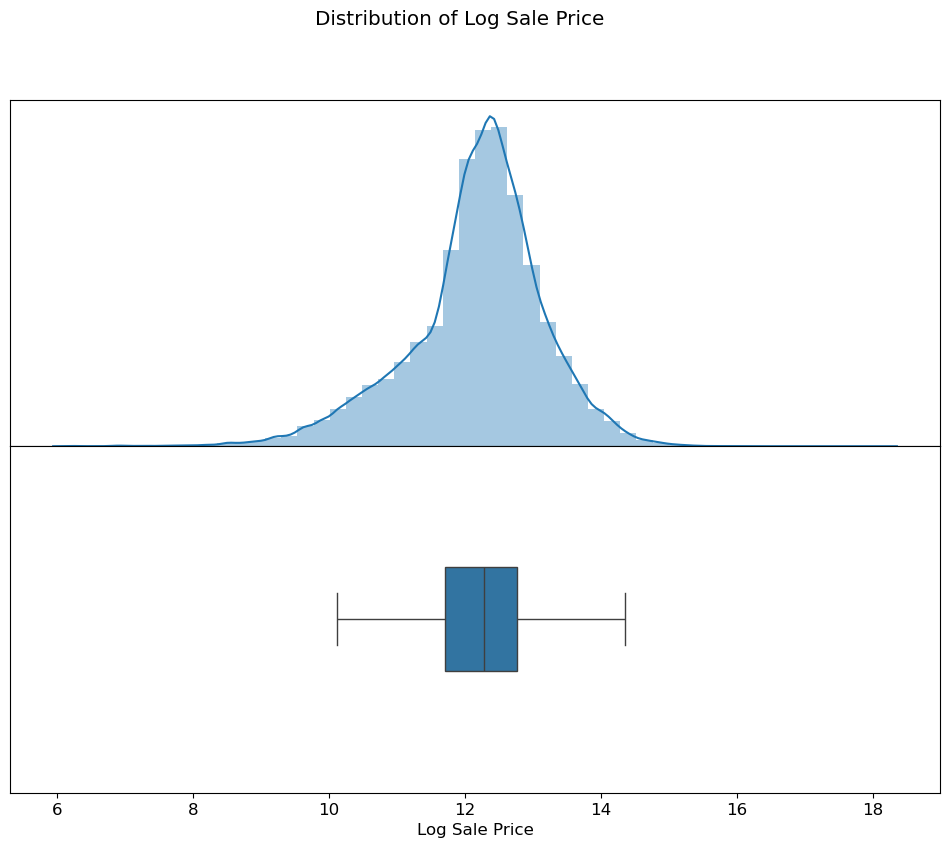

In [60]:
plot_distribution(training_data, label='Log Sale Price');

In [61]:
training_data['Log Sale Price'].describe()

count    168931.000000
mean         12.168227
std           0.999586
min           6.214608
25%          11.703546
50%          12.278393
75%          12.765688
max          18.078190
Name: Log Sale Price, dtype: float64

In [62]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

I see a strong concentration of datapoints around the simple linear regression line. This gives us a good correlation.

In [63]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a DataFrame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] <= upper) & (data[variable] >= lower)]

In [64]:
pd.set_option('display.max_colwidth', None)
training_data.loc[0:5, 'Description']

1                               This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.
2                             This property, sold on 02/18/2016, is a one-story houeshold located at 11415 S PRAIRIE AVE.It has a total of 7 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.
3    This property, sold on 07/23/2013, is a one-story with partially livable attics houeshold located at 2012 DOBSON ST.It has a total of 5 rooms, 3 of which are bedrooms, and 1.5 of which are bathrooms.
4                                    This property, sold on 06/10/2016, is a one-story houeshold located at 104 SAUK TRL.It has a total of 5 rooms, 2 of which are bedrooms, and 1.0 of which are bathrooms.
Name: Description, dtype: object

In [65]:
q5a = [1, 2, 4, 6, 7, 8]

In [66]:
def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.

    Output:
      a Dataframe with a new column "Bedrooms" containing ints.

    """
    with_rooms = data.copy()
    #match number following a single space, "rooms," then a comma
    with_rooms['Bedrooms'] = with_rooms['Description'].str.findall(r' (\d+) rooms,').str[0].fillna(0).astype(int)
    return with_rooms

training_data = add_total_bedrooms(training_data)

In [67]:
#checking that add_total_bedrooms worked
training_data.head(3)

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.",3780.0,12.560244,6.904751,6
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-story houeshold located at 11415 S PRAIRIE AVE.It has a total of 7 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.",4375.0,9.998798,6.810142,7
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-story with partially livable attics houeshold located at 2012 DOBSON ST.It has a total of 5 rooms, 3 of which are bedrooms, and 1.5 of which are bathrooms.",4375.0,12.323856,7.068172,5


Text(0.5, 1.0, 'Distribution of Log Sale Price Depending on Number of Bedrooms')

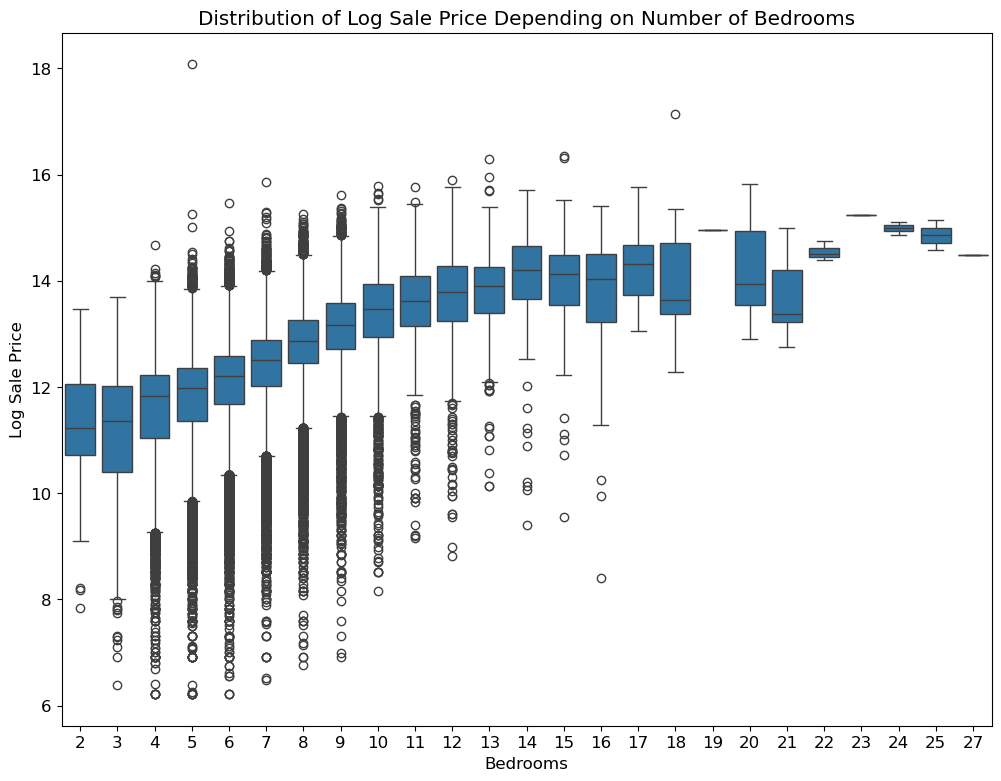

In [68]:
sns.boxplot(data = training_data, x = 'Bedrooms', y = 'Log Sale Price')
plt.title('Distribution of Log Sale Price Depending on Number of Bedrooms')

In [69]:
num_neighborhoods = (training_data['Neighborhood Code']).nunique()
num_neighborhoods

193

In [70]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

Looks like I have run into the problem of overplotting again.

The graph is overplotted because **there are actually quite a few neighborhoods in this dataset**! For the clarity of our visualization, I will have to zoom in again on a few of them. The reason for this is that the visualization will become quite cluttered with a super dense x-axis.

Assign the variable `in_top_20_neighborhoods` to a copy of `training_data` that has been filtered to only contain rows corresponding to properties that are in one of the top 20 most populous neighborhoods. I define the “top 20 neighborhoods” as being the 20 neighborhood codes that have the greatest number of properties within them.

In [71]:
(training_data['Neighborhood Code']).value_counts(20)

Neighborhood Code
30     0.051802
80     0.042426
10     0.037157
70     0.034482
50     0.032948
         ...   
99     0.000030
134    0.000030
145    0.000018
341    0.000006
106    0.000006
Name: proportion, Length: 193, dtype: float64

In [72]:
top_20_neighborhood_codes = training_data['Neighborhood Code'].value_counts().head(20).index.tolist()
in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].isin(top_20_neighborhood_codes)]

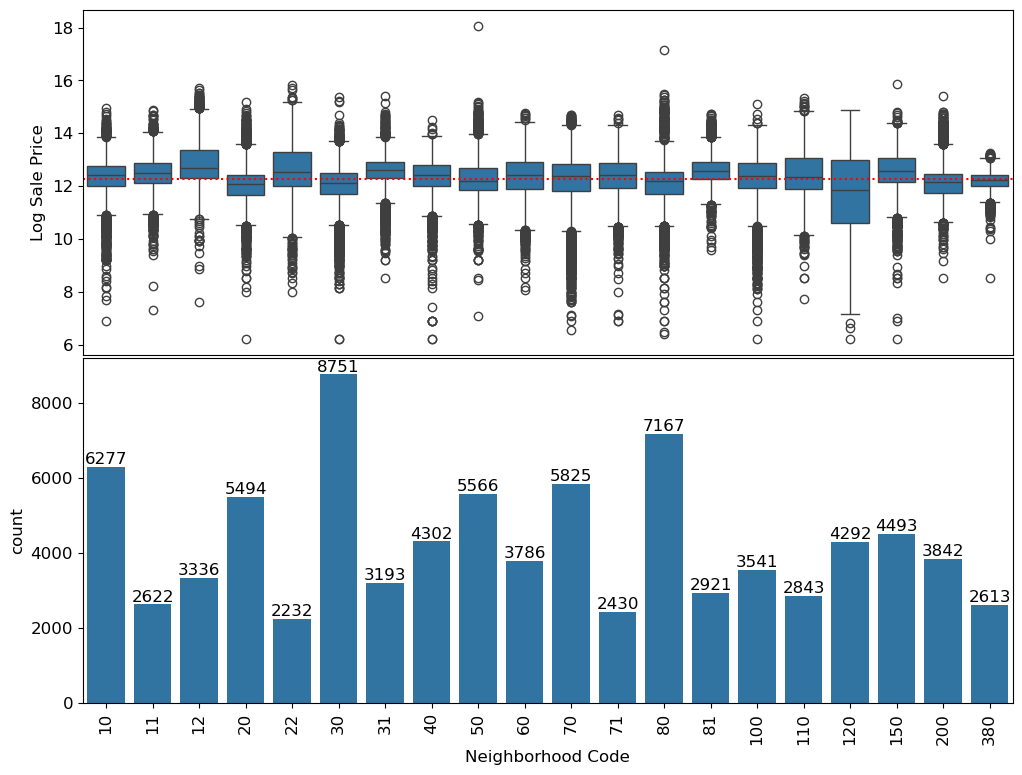

In [73]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

In [74]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least a int-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods 
      as measured by the metric function
    """
    neighborhoods = data.groupby('Neighborhood Code').agg({'Log Sale Price': metric}).sort_values(by='Log Sale Price', ascending=False).index[:n]
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

In [75]:
def add_in_expensive_neighborhood(data, expensive_neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(expensive_neighborhoods).astype(int)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

In [76]:
def substitute_roof_material(data):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      DataFrame identical to the input except with a refactored 'Roof Material' column
    """
    data = data.replace({'Roof Material':{
        1: 'Shingle/Asphalt',
        2: 'Tar & Gravel',
        3: 'Slate',
        4: 'Shake',
        5: 'Tile',
        6: 'Other'
    }})
    return data
    
training_data_mapped = substitute_roof_material(training_data)
training_data_mapped.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.",3780.0,12.560244,6.904751,6,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-story houeshold located at 11415 S PRAIRIE AVE.It has a total of 7 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.",4375.0,9.998798,6.810142,7,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-story with partially livable attics houeshold located at 2012 DOBSON ST.It has a total of 5 rooms, 3 of which are bedrooms, and 1.5 of which are bathrooms.",4375.0,12.323856,7.068172,5,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-story houeshold located at 104 SAUK TRL.It has a total of 5 rooms, 2 of which are bedrooms, and 1.0 of which are bathrooms.",8400.0,10.025705,6.855409,5,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-story with partially livable attics houeshold located at 2820 186TH ST.It has a total of 6 rooms, 4 of which are bedrooms, and 1.5 of which are bathrooms.",10890.0,11.512925,7.458186,6,0


In [77]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """
    enc = OneHotEncoder()
    enc.fit(data[['Roof Material']])
    new_columns = pd.DataFrame(enc.transform(data[['Roof Material']]).toarray(),
                               columns = enc.get_feature_names_out(),
                               index = data.index)
    return pd.concat((data, new_columns), axis = 1)

training_data_ohe = ohe_roof_material(training_data_mapped)
# This line of code will display only the one-hot-encoded columns in training_data_ohe that 
# have names that begin with “Roof Material_" 
training_data_ohe.filter(regex='^Roof Material_').head(10)

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar & Gravel,Roof Material_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


<hr style="border: 1px solid #fdb515;" />
<hr style="border: 5px solid #003262;" />
<br/><br/>

This dataset is split into a training/validation set and a testing set. Importantly, the test set does not contain values for my target variable, `Sale Price`. In this project, I train a model on the training/validation set then use this model to predict the `Sale Price`s of the test set. In the cell below, I load the training/validation set into the `DataFrame` `training_val_data` and the test set into the `DataFrame` `test_data`.

In [78]:
training_val_data = pd.read_csv("data/cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("data/cook_county_contest_test.csv", index_col='Unnamed: 0')

As a good sanity check, I verify that the data shape matches the description.

In [79]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

In [80]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

1. Buyers need to know housing prices to gauge how to manage their purchasing budget and timing.
2. Sellers would likely prefer to sell when the housing prices are high rather than low. Knowing housing prices would be beneficial for them to make the most profit on their property.
3. Real estate agents would be interested in knowing housing prices as Ill since it directly impacts their commission income.

I find that an assessment process which systematically overvalues lower-priced properties and undervalues higher-priced ones creates significant barriers for low-income buyers. If an affordable home is assessed too high, it can mislead budget-constrained buyers into thinking the property is out of reach—effectively pricing them out. Conversely, buyers with higher budgets might benefit from under-assessed high-value homes, gaining access to properties they otherwise might have overlooked. This dynamic feels especially unfair because it disproportionately disadvantages those with fewer housing options to begin with.

The assessment process failed to meet basic standards of accuracy and fairness. Due to these skewed valuations, property taxes ended up being higher for low-income homeowners and lower for high-income ones, contributing to an inequitable gap between Black and white property owners. While an appeals process technically exists, it is not equally accessible in practice. Some communities rarely file appeals, often because of limited resources or awareness, while others appeal frequently. Notably, the areas that almost never appeal are also the ones where properties are consistently overvalued, further entrenching the imbalance.

Encoding race also made it possible for the real estate system to carry out racial discrimination widely. Non-white property owners continue to carry the burden of a long history of segregation, redlining, and systemic exclusion. The appeals process, while technically available to all, implicitly favors white property owners who are more likely to have the financial resources and legal knowledge to navigate it. As a result, overvalued assessments are more likely to remain unchallenged for non-white homeowners, making these inflated property values and their associated tax burdens more entrenched and difficult to correct.

In [81]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    split_indices = int(data_len * 0.8)
    train = data.iloc[shuffled_indices[:split_indices]]
    validation = data.iloc[shuffled_indices[split_indices:]]
   
    return train, validation
train, validation = train_val_split(training_val_data)

<br>

### Pipeline function

To streamline my workflow, I created a pipeline function that encapsulates all the necessary feature engineering steps for the first model. Rather than calling each transformation function manually, the pipeline wraps them into a single reusable function that takes in the raw dataset and returns X and Y.

This approach ensures consistency across training and validation splits, and makes the notebook cleaner and easier to maintain.

The helper functions used in this pipeline, such as remove_outliers, log_transform, and add_total_bedrooms, are defined earlier in the notebook.

In [89]:
from feature_func_inline import *    # Import functions from Project A1


def process_data_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bedroom column
    data = add_total_bedrooms(data)
    # Select X and Y from the full data
    X = data[['Bedrooms']]
    Y = data['Log Sale Price']
    return X, Y

# Reload the data
full_data = pd.read_csv("data/cook_county_train.csv")

# Process the data using the pipeline for the first model.
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, Y_train_m1_simple = process_data_simple(train_m1)
X_valid_m1_simple, Y_valid_m1_simple = process_data_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(Y_train_m1_simple.head())

,Bedrooms
163803,4
69817,8
11374,5
140562,5
37232,7


163803    12.608199
69817     12.409013
11374     11.630709
140562     8.517193
37232     11.641758
Name: Log Sale Price, dtype: float64

### `.pipe`

Alternatively, I build the pipeline using `pd.DataFrame.pipe` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html)).

The following function `process_data_pipe` takes in a `DataFrame` `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case). I can use this function with each of the tuples passed in through `pipeline_functions`.

In [90]:
# Define process_data_pipe.
def process_data_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

In [98]:
# Reload the data
full_data = pd.read_csv("data/cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'column': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'column': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]

X_train_m1, Y_train_m1 = process_data_pipe(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, Y_valid_m1 = process_data_pipe(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by process_data_simple
display(X_train_m1.head())
display(Y_train_m1.head())

,Bedrooms
163803,4
69817,8
11374,5
140562,5
37232,7


163803    12.608199
69817     12.409013
11374     11.630709
140562     8.517193
37232     11.641758
Name: Log Sale Price, dtype: float64

In [99]:
# Set the random seed for reproducibility
np.random.seed(1337)

# Split the full dataset into training and validation sets for Model 2
train_m2, valid_m2 = train_val_split(full_data)

# Define the processing pipeline for Model 2
m2_pipelines = [
    (remove_outliers, None, {
        'column': 'Sale Price',  # ✅ fixed key name
        'lower': 499,
    }),
    (log_transform, None, {'column': 'Sale Price'}),
    (log_transform, None, {'column': 'Building Square Feet'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)
]

# Apply the pipeline to training and validation data
X_train_m2, Y_train_m2 = process_data_pipe(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, Y_valid_m2 = process_data_pipe(valid_m2, m2_pipelines, 'Log Sale Price')

# Preview results
display(X_train_m2.head())
display(Y_train_m2.head())

,Bedrooms,Log Building Square Feet
163803,4,6.860664
69817,8,7.397562
11374,5,7.051856
140562,5,6.813445
37232,7,7.031741


163803    12.608199
69817     12.409013
11374     11.630709
140562     8.517193
37232     11.641758
Name: Log Sale Price, dtype: float64

I first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for both of our models. I set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept (i.e., a bias term).

In [100]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

In [101]:
X_train_m1

,Bedrooms
163803,4
69817,8
11374,5
140562,5
37232,7
...,...
71538,8
153946,6
117415,7
9448,8


In [102]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, Y_train_m1)
# Compute the fitted and predicted values of Log Sale Price for the 1st model
Y_fitted_m1 = linear_model_m1.predict(X_train_m1)
Y_predicted_m1 = linear_model_m1.predict(X_valid_m1)

# Fit the 2nd model
linear_model_m2.fit(X_train_m2, Y_train_m2)
# Compute the fitted and predicted values of Log Sale Price for the 2nd model
Y_fitted_m2 = linear_model_m2.predict(X_train_m2)
Y_predicted_m2 = linear_model_m2.predict(X_valid_m2)

In [103]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

Text(0.5, 1.0, 'Residual vs Original Log Sale Price')

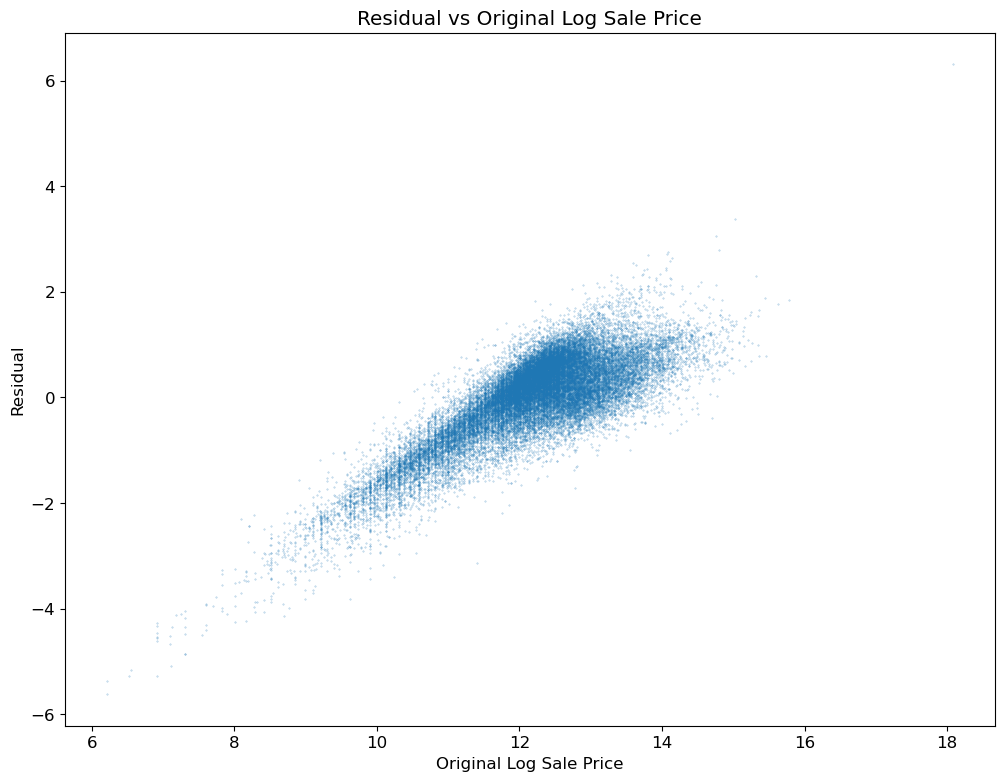

In [104]:
plt.scatter(x = Y_valid_m2, y = Y_valid_m2 - Y_predicted_m2, s = 0.1, alpha = 0.5)
plt.xlabel('Original Log Sale Price')
plt.ylabel('Residual')
plt.title('Residual vs Original Log Sale Price')

While my model explains some of the variability in price, there is certainly still a lot of room for improvement to be made. One reason is I have been only utilizing 1 or 2 features (out of a total of 70+) so far!

In [115]:
# Evaluate the model using RMSE
from sklearn.metrics import mean_squared_error

def evaluate_model(model, X, y, label=""):
    """
    Fits the model on X and y, prints and returns RMSE.

    Parameters:
        model: An sklearn estimator (e.g., LinearRegression)
        X: Features DataFrame
        y: Target Series
        label (str): Optional label to identify the run

    Returns:
        float: RMSE score on the training data
    """
    model.fit(X, y)
    preds = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, preds))
    if label:
        print(f"{label} RMSE: {rmse:.4f}")
    else:
        print(f"RMSE: {rmse:.4f}")
    return rmse

In [116]:
from sklearn.linear_model import LinearRegression

def remove_outliers(data, column, lower=-np.inf, upper=np.inf):
    return data[(data[column] <= upper) & (data[column] >= lower)]

def rm_outliers_pct(data, columns, l=25, h=75):
    for col in columns:
        low = np.percentile(data[col], l)
        high = np.percentile(data[col], h)
        data = remove_outliers(data, col, lower=low, upper=high)
    return data

def log_cols(data, columns):
    for col in columns:
        data['Log ' + col] = np.log(data[col].clip(lower=1e-9))  # avoid log(0)
    return data

def exp_cols(data, columns, n):
    for col in columns:
        data['Exp ' + col] = data[col] ** n
    return data

def process_data_final(data, is_test_set=False):
    data = log_cols(data, ['Building Square Feet', 'Land Square Feet', 'Estimate (Building)', 'Estimate (Land)'])
    data = exp_cols(data, ['Fireplaces', 'Repair Condition'], n=3)

    data = add_total_bedrooms(data)
    data = pd.get_dummies(data, prefix='RM', columns=['Roof Material'])
    
    if not is_test_set:
        data['Log Sale Price'] = np.log(data['Sale Price'].clip(lower=1e-9))
        data = rm_outliers_pct(data, ['Sale Price', 'Land Square Feet', 'Estimate (Building)', 'Estimate (Land)'])
        keep_cols = ['Log Sale Price', 'Log Building Square Feet', 'Log Land Square Feet',
                     'Log Estimate (Building)', 'Log Estimate (Land)', 'Exp Fireplaces', 'Exp Repair Condition',
                     'Central Air', 'Bedrooms', 'RM_1.0', 'RM_2.0', 'RM_3.0', 'RM_4.0', 'RM_5.0', 'RM_6.0']
        data = data[keep_cols]
        X = data.drop(['Log Sale Price'], axis=1)
        y = data['Log Sale Price']
        return X, y
    else:
        else_cols = ['Log Building Square Feet', 'Log Land Square Feet', 'Log Estimate (Building)', 'Log Estimate (Land)',
                     'Exp Fireplaces', 'Exp Repair Condition', 'Central Air', 'Bedrooms', 'RM_1.0', 'RM_2.0', 'RM_3.0',
                     'RM_4.0', 'RM_5.0', 'RM_6.0']
        data = data[else_cols]
        return data

# Load and evaluate
df = pd.read_csv("data/cook_county_train.csv")
X_final, y_final = process_data_final(df)

model = LinearRegression()
evaluate_model(model, X_final, y_final, label="Final Model")

Final Model RMSE: 0.3716


0.37161837157363287

In [117]:
from sklearn.linear_model import LinearRegression
from datetime import datetime
from IPython.display import display, HTML
import pandas as pd

# Load test set
df_test = pd.read_csv("data/cook_county_contest_test.csv")

# Preprocess the test data
X_test = process_data_final(df_test, is_test_set=True)

# Fit model on full training data
df_train = pd.read_csv("data/cook_county_train.csv")
X_train, y_train = process_data_final(df_train)

model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test data, handling any inf or NaN values
if np.isinf(X_test.values).any() or np.isnan(X_test.values).any():
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
y_test_pred = model.predict(X_test)

# Build submission DataFrame
submission_df = pd.DataFrame({
    "Id": df_test['Unnamed: 0'],
    "Value": y_test_pred
})

# Save with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"submission_{timestamp}.csv"
submission_df.to_csv(filename, index=False)

# Show download link
display(HTML(f"✅ Download test prediction <a href='{filename}' download>here</a>."))


TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [118]:
# ...existing code...
from sklearn.linear_model import LinearRegression
from datetime import datetime
from IPython.display import display, HTML
import pandas as pd

# Load test set
df_test = pd.read_csv("data/cook_county_contest_test.csv")

# Preprocess the test data
X_test = process_data_final(df_test, is_test_set=True)

# Fit model on full training data
df_train = pd.read_csv("data/cook_county_train.csv")
X_train, y_train = process_data_final(df_train)

model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test data, handling any inf or NaN values
if np.isinf(X_test.values).any() or np.isnan(X_test.values).any():
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
y_test_pred = model.predict(X_test)

# Build submission DataFrame
submission_df = pd.DataFrame({
    "Id": df_test['Unnamed: 0'],
    "Value": y_test_pred
})

# Save with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"submission_{timestamp}.csv"
submission_df.to_csv(filename, index=False)

# Show download link
display(HTML(f"✅ Download test prediction <a href='{filename}' download>here</a>."))
# ...existing code...

TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# Check if prediction is reasonable. 
submission_df["Value"].describe()

count    55311.000000
mean        12.222983
std          0.767159
min          6.381357
25%         11.728900
50%         12.204383
75%         12.661494
max         16.774387
Name: Value, dtype: float64

In [ ]:
# Run the cell below
train_df = pd.read_csv('cook_county_train.csv')
X, Y = process_data_final(train_df)
model = lm.LinearRegression(fit_intercept=True)
model.fit(X, Y)
Y_pred = model.predict(X)

In [ ]:
# Obtain the two subsets of data.
small_interval = (8, 11)
big_interval = (11, 14)
Y = pd.DataFrame(Y)
Y_small = Y[(Y['Log Sale Price'] > small_interval[0]) & (Y['Log Sale Price'] < small_interval[1])]['Log Sale Price']
Y_big = Y[(Y['Log Sale Price'] > big_interval[0]) & (Y['Log Sale Price'] < big_interval[1])]['Log Sale Price']
X_small = X.loc[Y_small.index]
X_big = X.loc[Y_big.index]

**Compute the RMSE of the model's predictions on each subset separately** and assign those values to `rmse_small` and `rmse_big` respectively. Here, I am looking for the RMSE **with regard to `Sale Price`**. I have to exponentiate my predictions and response vectors before computing the RMSE using the `rmse` function defined earlier!

Separately, I also want to understand whether the proportion of houses in each interval that the model overestimates the value of the actual `Sale Price`. To that end, **compute the proportion of predictions strictly greater than the corresponding true price in each subset** and assign it to `prop_overest_small` and `prop_overest_big` respectively. For example, if I am working with a dataset of 3 houses wherein the actual `Log Sale Price`s Ire [10, 11, 12] and the model predictions Ire [5, 15, 13], then the proportion of houses with overestimated values would be 2/3.  

In [126]:
rmse_small = rmse(np.exp(model.predict(X_small)), np.exp(Y_small))
rmse_big = rmse(np.exp(model.predict(X_big)), np.exp(Y_big))

prop_overest_small = np.mean(np.exp(model.predict(X_small)) >= np.exp(Y_small))
prop_overest_big = np.mean(np.exp(model.predict(X_big)) >= np.exp(Y_big))

print(f"The RMSE for properties with log sale prices in the interval {small_interval} is {np.round(rmse_small)}")
print(f"The RMSE for properties with log sale prices in the interval {big_interval} is {np.round(rmse_big)}")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {small_interval} is {100 * np.round(prop_overest_small, 3)}%")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {big_interval} is {100 * np.round(prop_overest_big, 3)}%")

The RMSE for properties with log sale prices in the interval (8, 11) is 82756.0
The RMSE for properties with log sale prices in the interval (11, 14) is 53374.0
The percentage of overestimated values for properties with log sale prices in the interval (8, 11) is 100.0%
The percentage of overestimated values for properties with log sale prices in the interval (11, 14) is 41.0%


In [ ]:
def rmse_interval(X, Y, start, end):
    '''
    Given a design matrix X and response vector Y, computes the RMSE for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval (start, end).

    Input: 
    X - 2D DataFrame representing the design matrix.
    Y - 1D DataFrame consisting of a single column labeled 'Log Sale Price'.
    start - A float specifying the start of the interval (exclusive).
    end - A float specifying the end of the interval (exclusive).
    '''
    
    Y_subset = Y[(Y['Log Sale Price'] > start) & (Y['Log Sale Price'] < end)]['Log Sale Price']
    X_subset = X.loc[Y_subset.index]

    if len(X_subset) == 0:
        return 0

    Y_pred_subset = model.predict(X_subset)
    Y_true_subset = np.exp(Y_subset)
    Y_pred_subset = np.exp(Y_pred_subset)
        
    rmse_subset = rmse(Y_true_subset, Y_pred_subset)
    return rmse_subset
    
def prop_overest_interval(X, Y, start, end):
    '''
    Given a design matrix X and response vector Y, computes prop_overest for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval (start, end).

    Input: 
    X - 2D DataFrame representing the design matrix.
    Y - 1D DataFrame consisting of a single column labeled 'Log Sale Price'.
    start - A float specifying the start of the interval (exclusive).
    end - A float specifying the end of the interval (exclusive).
    '''
    
    Y_subset = Y[(Y['Log Sale Price'] > start) & (Y['Log Sale Price'] < end)]['Log Sale Price']
    X_subset = X.loc[Y_subset.index]

    # DO NOT MODIFY THESE TWO LINES
    if len(X_subset) == 0:
        return 0

    Y_pred_subset = model.predict(X_subset)
    Y_true_subset = np.exp(Y_subset)
    Y_pred_subset = np.exp(Y_pred_subset)

    prop_subset = np.mean(Y_pred_subset > Y_true_subset)
    return prop_subset

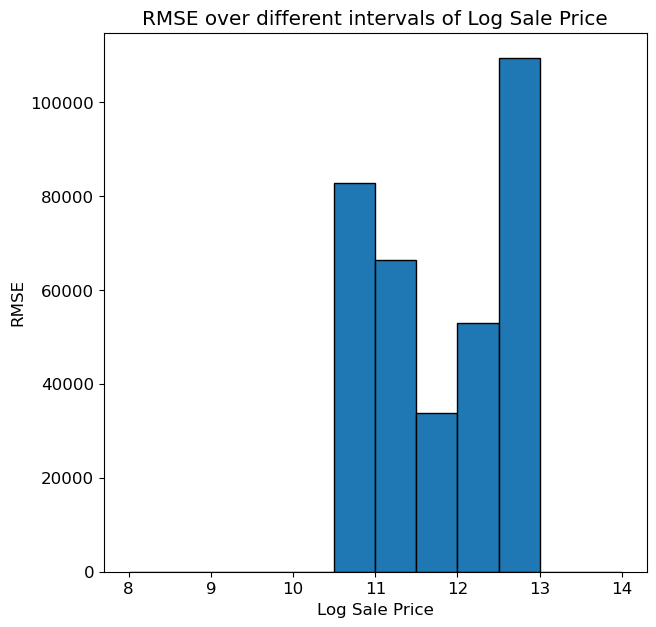

In [ ]:
# Generate the plot for RMSE over different intervals of Log Sale Price
rmses = []
for i in np.arange(8, 14, 0.5):
    rmses.append(rmse_interval(X, Y, i, i + 0.5))
plt.figure(figsize = (7, 7))
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = rmses, edgecolor = 'black', width = 0.5)
plt.title('RMSE over different intervals of Log Sale Price')
plt.xlabel('Log Sale Price')
plt.ylabel('RMSE');

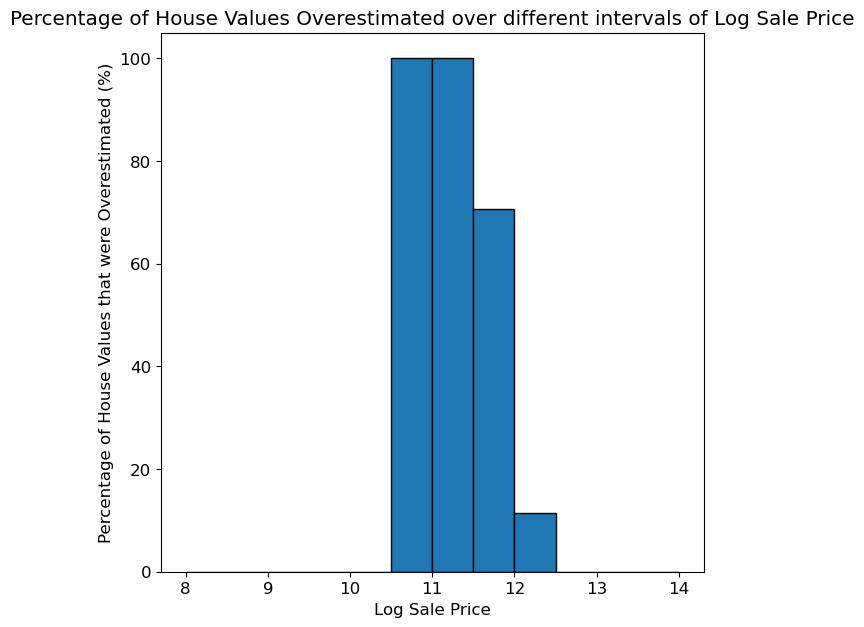

In [ ]:
# Generate the plot for percentage of overestimated values over different intervals of Log Sale Price
props = []
for i in np.arange(8, 14, 0.5):
    props.append(prop_overest_interval(X, Y, i, i + 0.5) * 100)
plt.figure(figsize = (7, 7))
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = props, edgecolor = 'black', width = 0.5)
plt.title('Percentage of House Values Overestimated over different intervals of Log Sale Price')
plt.xlabel('Log Sale Price')
plt.ylabel('Percentage of House Values that were Overestimated (%)');

Explicitly referencing **any ONE** of the plots above (using `props` and `rmses`), explain whether the assessments your model predicts more closely align with scenario C or scenario D that I discussed back in `1b`. Which of the two plots would be more useful in ascertaining whether the assessments tended to result in progressive or regressive taxation? Provide a brief explanation to support your choice of plot. For your reference, the scenarios are also shown below:

    C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  
    D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.

Based on the second plot, the loIr end of the log sale price has almost all of its properties overvalued while the more expensive houses Ire less overestimation of its value. I think that scenario C is happening here. The second plot is more useful to ascertain whether the assessments tended to result in progressive or regressive taxation because I can see how the "percentage of house values that Ire overestimated (%)" changes as the property value changes. Regressive taxation shows up when there's a higher percentage for higher valued properties. Progressive taxation shows up when the plot shows overestimation for higher valued properties.

The residual means whether the house is overvalued or undervalued in comparison to the true market value. The individual homeowner would prefer a negative residual because that means loIr property taxes they need to pay. Positive residuals, on the other hand, would mean more property taxes.